## Implicit Quantile Networks for Event Folding
Created: June 13, 2022 Ali & Harrison<br>

### Introduction 



In [11]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split
# linearly transform a feature to zero mean and unit variance
from sklearn.preprocessing import StandardScaler

# to reload modules
import importlib

%matplotlib inline

In [12]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

### Load training data

In [13]:
data    = pd.read_csv('Data.csv')
print('number of entries:', len(data))

columns = list(data.columns)[1:]
print('\nColumns:', columns)

fields  = list(data.columns)[5:]
print('\nFields:', fields)

target  = 'RecoDataphi'
print('\nTarget:', target )

features= [x for x in fields]
features.remove(target)

print('\nFeatures:', features)

data    = data[fields]
data[:5]

number of entries: 100000

Columns: ['rawRecoDatapT', 'rawRecoDataeta', 'rawRecoDataphi', 'rawRecoDatam', 'RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Fields: ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target: RecoDataphi

Features: ['RecoDatapT', 'RecoDataeta', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']


,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [14]:
# Fraction of the data assigned as test data
fraction = 20/100
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 5/80
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         75000
validation set size:     5000
test set size:          20000


Split data into targets $t$ and inputs $\mathbf{x}$

In [15]:
target, features

('RecoDataphi',
 ['RecoDatapT',
  'RecoDataeta',
  'RecoDatam',
  'genDatapT',
  'genDataeta',
  'genDataphi',
  'genDatam',
  'tau'])

In [16]:
def split_t_x(df, target, source, scalers):
    # change from pandas dataframe format to a numpy array
    scaler_t, scaler_x = scalers
    t = np.array(scaler_t.transform(df[target].to_numpy().reshape(-1, 1)))
    x = np.array(scaler_x.transform(df[source]))
    t = t.reshape(-1,)
    return t, x

# create a scaler for target
scaler_t = StandardScaler()
scaler_t.fit(train_data[target].to_numpy().reshape(-1, 1))

# create a scaler for inputs
scaler_x = StandardScaler()
scaler_x.fit(train_data[features])
# NB: undo scaling of tau, which is the last feature
scaler_x.mean_[-1] = 0
scaler_x.scale_[-1]= 1

scalers = [scaler_t, scaler_x]

train_t, train_x = split_t_x(train_data, target, features, scalers)
valid_t, valid_x = split_t_x(valid_data, target, features, scalers)
test_t,  test_x  = split_t_x(test_data,  target, features, scalers)

train_t.shape, train_x.shape

### Quantile regression

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),\\
\text{where } f_m & \equiv f(\mathbf{x}_m, \theta) .
\end{align}

We shall use the __quantile loss__ defined by

\begin{align}
L(t, f) & = \begin{cases}
    \tau (t - f), & \text{if } t \geq f \\
    (1 - \tau)(f - t)              & \text{otherwise} .
\end{cases}
\end{align}

To show that this loss function indeed leads to $\tau$-quantiles, consider the minimization of the __risk functional__

\begin{align}
R[f] & = \int \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x}, \\
\frac{\delta R}{\delta f}  & = 0 .
\end{align}

If the above is to hold $\forall\,\,\mathbf{x}$, then 

\begin{align}
\int \frac{\partial L}{\partial f} p(t | \mathbf{x}) \, dt & = 0,\\
-\tau \int_{t \ge f} p(t | \mathbf{x}) \, dt + (1 - \tau)\int_{t < f} p(t | \mathbf{x}) \, dt & = 0, \\
\therefore \quad\int_{t < f} p(t | \mathbf{x}) \, dt & = \tau.
\end{align}

### Save training utilities to file SIR_dnn_util.py 

  1. get_batch
  1. average_quadratic_loss
  1. average_cross_entropy_loss
  1. average_quantile_loss
  1. validate
  1. ModelHandler
  1. train
  1. plot_average_loss
  1. hist_data

Time ut.get_batch

In [17]:
from time import time
start = time()
batch_size = 50
N = 1000
for i in range(N):
    ut.get_batch(train_x, train_t, batch_size)
endtime = 1e6*(time() - start)/N
print('time: %10.1f micro-sec' %  endtime)

time:       43.7 micro-sec


In [18]:
%%writefile iqnutil.py

import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset

# return a batch of data for the next step in minimization
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)

# A simple wrapper around a model to make using the latter more
# convenient
class ModelHandler:
    def __init__(self, model, scalers):
        self.model  = model
        self.scaler_t, self.scaler_x = scalers
        
        self.scale  = self.scaler_t.scale_[0] # for output
        self.mean   = self.scaler_t.mean_[0]  # for output
        self.fields = self.scaler_x.feature_names_in_
        
    def __call__(self, df):
        
        # scale input data
        x  = np.array(self.scaler_x.transform(df[self.fields]))
        x  = torch.Tensor(x)

        # go to evaluation mode
        self.model.eval()
    
        # compute,reshape to a 1d array, and convert to a numpy array
        Y  = self.model(x).view(-1, ).detach().numpy()
        
        # rescale output
        Y  = self.mean + self.scale * Y
        
        if len(Y) == 1:
            return Y[0]
        else:
            return Y
        
    def show(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                print()
        
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

def plot_average_loss(traces, ftsize=18):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()
    

Overwriting iqnutil.py


In [19]:
import iqnutil as ut
importlib.reload(ut);

### Define model $f(\mathbf{x}, \theta)$

For simple models, it is sufficient to use the __Sequential__ class.

In [20]:
filename = 'iqn_model_phi.py'

In [21]:
%%writefile {filename}

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear( 8, 50),
                      nn.ReLU(),
                      
                      nn.Linear(50, 50),
                      nn.ReLU(),
                      
                      nn.Linear(50, 50),
                      nn.ReLU(), 
 
                      nn.Linear(50, 50),
                      nn.ReLU(), 
 
                      nn.Linear(50, 1)) 

Writing iqn_model_phi.py


### Train!

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=1, bias=True)
)
Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.440724	  0.442226
    249990	  0.118195	  0.132924


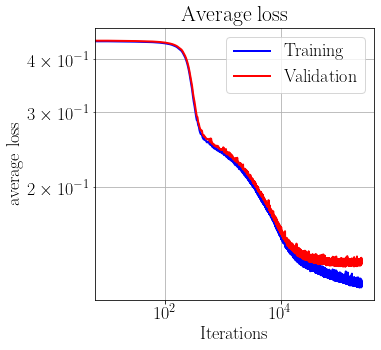

In [22]:
import iqn_model_phi as iqn
importlib.reload(iqn)
model = iqn.model
print(model)

n_batch       = 50
n_iterations  = 250000

learning_rate = 2.e-4
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

traces = ut.train(model, optimizer, 
                  ut.average_quantile_loss,
                  ut.get_batch,
                  train_x, train_t, 
                  valid_x, valid_t,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

ut.plot_average_loss(traces)

# save model parameter dictionary
torch.save(model.state_dict(), 'iqn_model_phi.dict')

In [23]:
dnn = ut.ModelHandler(model, scalers)

### Plot results of trained model

In [25]:
def plot_model(df, dnn,
               gfile='fig_model.png', 
               fgsize=(6, 6), 
               ftsize=20):
        
    # ----------------------------------------------
    # histogram RecoDatapT
    # ----------------------------------------------
    xmin, xmax = -5, 5
    xbins = 100
    xstep = (xmax - xmin)/xbins

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    #ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r'$\eta$', fontsize=ftsize)

    ax.hist(df['RecoDataeta'], 
            bins=xbins, 
            range=(xmin, xmax), alpha=0.3, color='blue')
   
    y = dnn(df)
    
    ax.hist(y, 
            bins=xbins, 
            range=(xmin, xmax), 
            alpha=0.3, 
            color='red')
    ax.grid()

    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

$p(reco) = \int p(reco | gen) \pi(gen) dgen$

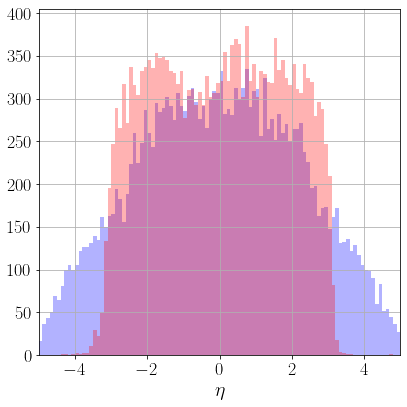

In [26]:
plot_model(test_data, dnn)